# CNN Extractor + Regressor

### Constant

In [1]:
DATA_PATH = "../../data.nosync/subj01"
EXTRACTOR = "resnet50-imagenet1k-v2"
LAYER = "avgpool"

## Load data

In [2]:
from sklearn.model_selection import train_test_split
from src import dataset

l_feat, l_frmi = dataset.get_dataset(
    DATA_PATH, EXTRACTOR, LAYER, "L", True)
r_feat, r_frmi = dataset.get_dataset(
    DATA_PATH, EXTRACTOR, LAYER, "R", True)

# normalize
r_feat = (r_feat - r_feat.mean()) / r_feat.std()
r_feat = (r_feat - r_feat.mean()) / r_feat.std()

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(
    l_feat, l_frmi, train_size=0.8)
print("X_train_l shape: {}".format(X_train_l.shape))
print("y_train_; shape: {}".format(y_train_l.shape))
print("X_test_l shape: {}".format(X_test_l.shape))
print("y_test_l shape: {}".format(y_test_l.shape))

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    r_feat, r_frmi, train_size=0.8)
print("X_train_l shape: {}".format(X_train_r.shape))
print("y_train_; shape: {}".format(y_train_r.shape))
print("X_test_l shape: {}".format(X_test_r.shape))
print("y_test_l shape: {}".format(y_test_r.shape))


X_train_l shape: (7872, 2048)
y_train_; shape: (7872, 19004)
X_test_l shape: (1969, 2048)
y_test_l shape: (1969, 19004)
X_train_l shape: (7872, 2048)
y_train_; shape: (7872, 20544)
X_test_l shape: (1969, 2048)
y_test_l shape: (1969, 20544)


## Modelling

In [3]:
from sklearn.linear_model import LinearRegression

model_l = LinearRegression(n_jobs=8).fit(X=X_train_l, y=y_train_l)
model_r = LinearRegression(n_jobs=8).fit(X=X_train_r, y=y_train_r)

In [4]:
y_pred_l = model_l.predict(X_test_l)
y_pred_r = model_r.predict(X_test_r)

In [6]:
import numpy as np
from scipy.stats import pearsonr

def compute_perason(pred, target):

    corrcoef = list()
    for pred, target in zip(pred.T, target.T):

        s, _ = pearsonr(x=pred, y=target)
        corrcoef.append(s)

    return np.array(corrcoef)


lh_correlation = compute_perason(y_pred_l, y_test_l)
rh_correlation = compute_perason(y_pred_r, y_test_r)


/opt/miniconda3/envs/algonauts/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/algonauts/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


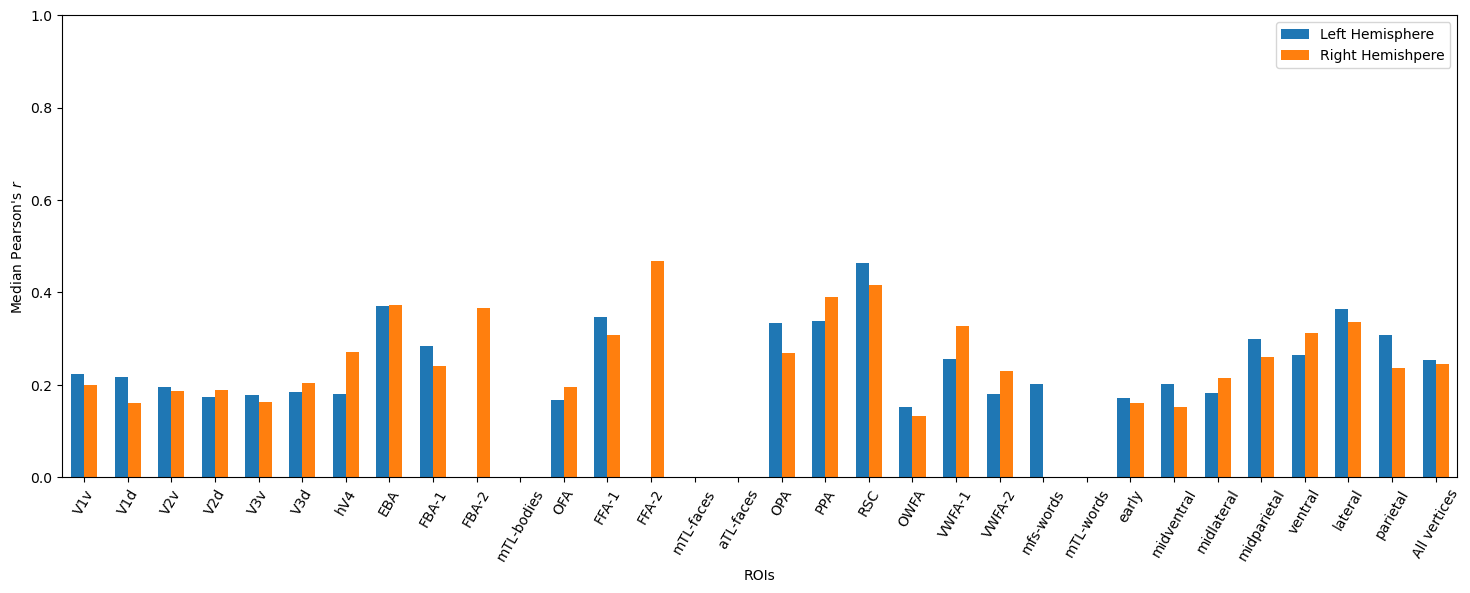

In [7]:
import os
import matplotlib.pyplot as plt

# Load the ROI classes mapping dictionaries
roi_mapping_files = ['mapping_prf-visualrois.npy', 'mapping_floc-bodies.npy',
                     'mapping_floc-faces.npy', 'mapping_floc-places.npy',
                     'mapping_floc-words.npy', 'mapping_streams.npy']
roi_name_maps = []
for r in roi_mapping_files:
    roi_name_maps.append(np.load(os.path.join(DATA_PATH, 'roi_masks', r),
                                 allow_pickle=True).item())

# Load the ROI brain surface maps
lh_challenge_roi_files = ['lh.prf-visualrois_challenge_space.npy',
                          'lh.floc-bodies_challenge_space.npy', 'lh.floc-faces_challenge_space.npy',
                          'lh.floc-places_challenge_space.npy', 'lh.floc-words_challenge_space.npy',
                          'lh.streams_challenge_space.npy']
rh_challenge_roi_files = ['rh.prf-visualrois_challenge_space.npy',
                          'rh.floc-bodies_challenge_space.npy', 'rh.floc-faces_challenge_space.npy',
                          'rh.floc-places_challenge_space.npy', 'rh.floc-words_challenge_space.npy',
                          'rh.streams_challenge_space.npy']
lh_challenge_rois = []
rh_challenge_rois = []
for r in range(len(lh_challenge_roi_files)):
    lh_challenge_rois.append(np.load(os.path.join(DATA_PATH, 'roi_masks',
                                                  lh_challenge_roi_files[r])))
    rh_challenge_rois.append(np.load(os.path.join(DATA_PATH, 'roi_masks',
                                                  rh_challenge_roi_files[r])))

# Select the correlation results vertices of each ROI
roi_names = []
lh_roi_correlation = []
rh_roi_correlation = []
for r1 in range(len(lh_challenge_rois)):
    for r2 in roi_name_maps[r1].items():
        if r2[0] != 0:  # zeros indicate to vertices falling outside the ROI of interest
            roi_names.append(r2[1])
            lh_roi_idx = np.where(lh_challenge_rois[r1] == r2[0])[0]
            rh_roi_idx = np.where(rh_challenge_rois[r1] == r2[0])[0]
            lh_roi_correlation.append(lh_correlation[lh_roi_idx])
            rh_roi_correlation.append(rh_correlation[rh_roi_idx])
roi_names.append('All vertices')
lh_roi_correlation.append(lh_correlation)
rh_roi_correlation.append(rh_correlation)

# Create the plot
lh_median_roi_correlation = [np.median(lh_roi_correlation[r])
                             for r in range(len(lh_roi_correlation))]
rh_median_roi_correlation = [np.median(rh_roi_correlation[r])
                             for r in range(len(rh_roi_correlation))]
plt.figure(figsize=(18, 6))
x = np.arange(len(roi_names))
width = 0.30
plt.bar(x - width/2, lh_median_roi_correlation, width, label='Left Hemisphere')
plt.bar(x + width/2, rh_median_roi_correlation, width, label='Right Hemishpere')
plt.xlim(left=min(x)-.5, right=max(x)+.5)
plt.ylim(bottom=0, top=1)
plt.xlabel('ROIs')
plt.xticks(ticks=x, labels=roi_names, rotation=60)
plt.ylabel('Median Pearson\'s $r$')
plt.legend(frameon=True, loc=1)
